In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgbm

from sklearn.metrics import mean_absolute_error

In [3]:
train_df = pd.read_csv('train_dataset.csv')
train_df.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [4]:
train_df.shape

(37224, 7)

In [5]:
df = train_df.groupby('date')[['target', 'temp_pred',]].agg({'target': 'sum', 'temp_pred': 'mean'}).reset_index()
df.head()

,date,target,temp_pred
0,2019-01-01,11126.866,4.375
1,2019-01-02,11547.210,1.500
2,2019-01-03,12235.564,-1.375
3,2019-01-04,12763.044,-0.125
4,2019-01-05,12735.145,1.500


In [6]:
df.shape

(1551, 3)

In [7]:
#add features of day-of-week, day-of-month, week, month, season
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df['dow'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week.astype('int32')
df['month'] = df['date'].dt.month
df['season'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

In [8]:
#add lag columns
shifted = df.copy()

for i in range(15):
    shifted[f'target_lag_{i+1}'] = shifted['target'].shift(i+1)
shifted.head()

,date,target,temp_pred,dow,day,week,month,season,year,target_lag_1,...,target_lag_6,target_lag_7,target_lag_8,target_lag_9,target_lag_10,target_lag_11,target_lag_12,target_lag_13,target_lag_14,target_lag_15
0,2019-01-01,11126.866,4.375,1,1,1,1,1,2019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,11547.210,1.500,2,2,1,1,1,2019,11126.866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,12235.564,-1.375,3,3,1,1,1,2019,11547.210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,12763.044,-0.125,4,4,1,1,1,2019,12235.564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,12735.145,1.500,5,5,1,1,1,2019,12763.044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#delete nans where there's no lag data (start of period)
shifted['na_sum'] = shifted.isna().sum(axis=1)
shifted = shifted[shifted['na_sum'] == 0]
shifted = shifted.drop('na_sum', axis=1)
shifted.shape

(1536, 24)

In [10]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.show()

In [11]:
def lgbm_cross_val(cols_to_drop, cat_features=[], df=shifted, h=4, cv=5):
    maes = []
    for i in range(cv):
        end_train = df['date'].max() - np.timedelta64(h*(i+1), 'M') + pd.offsets.MonthEnd()
        end_valid = df['date'].max() - np.timedelta64(h*i, 'M') + pd.offsets.MonthEnd()
        print(f'end train: {end_train}, end_valid: {end_valid}')
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['target']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['target']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )
       
        preds = lgbm_reg.predict(X_valid)
        lgbm_mae = mean_absolute_error(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': valid['date'], 'y_true': y_valid, 'y_pred': preds})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} MAE: {lgbm_mae}")
        maes.append(lgbm_mae)

        
    plotImp(lgbm_reg, X_train)

    return(maes)

# pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid)

end train: 2022-11-30 00:00:00, end_valid: 2023-04-30 00:00:00
[100]	valid_0's l2: 80357.8


[200]	valid_0's l2: 83272.2


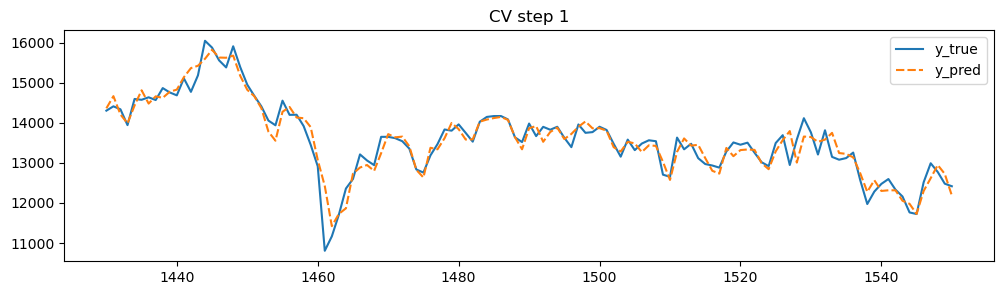

LGBM CV step 1 MAE: 190.98993170251035
end train: 2022-07-31 00:00:00, end_valid: 2022-11-30 00:00:00
[100]	valid_0's l2: 31430.8
[200]	valid_0's l2: 32153.7


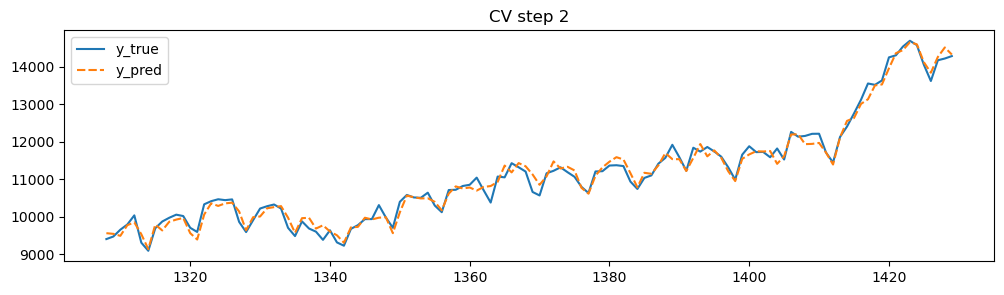

LGBM CV step 2 MAE: 135.1903430964517
end train: 2022-04-30 00:00:00, end_valid: 2022-07-31 00:00:00
[100]	valid_0's l2: 48618.4
[200]	valid_0's l2: 49810.9


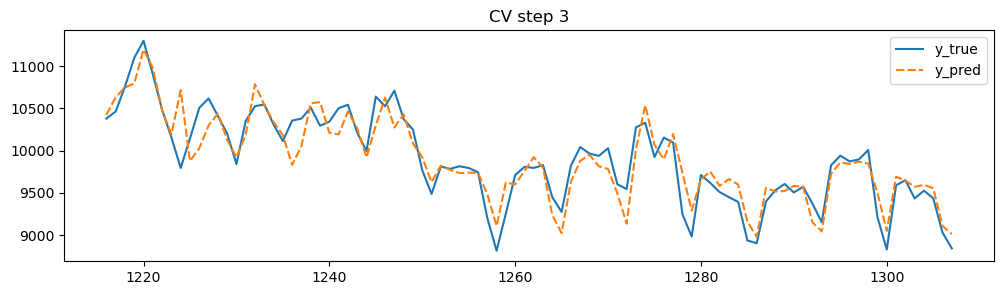

LGBM CV step 3 MAE: 161.11445624561398
end train: 2021-11-30 00:00:00, end_valid: 2022-04-30 00:00:00
[100]	valid_0's l2: 134805
[200]	valid_0's l2: 141984


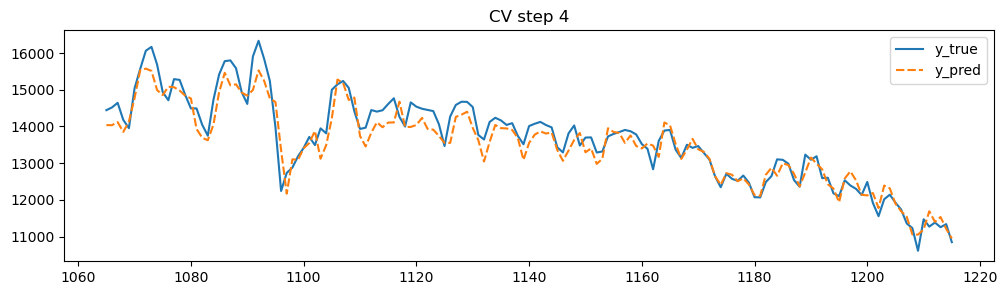

LGBM CV step 4 MAE: 291.755366263897
end train: 2021-07-31 00:00:00, end_valid: 2021-11-30 00:00:00
[100]	valid_0's l2: 38940.4
[200]	valid_0's l2: 40124.9
[300]	valid_0's l2: 40635.6


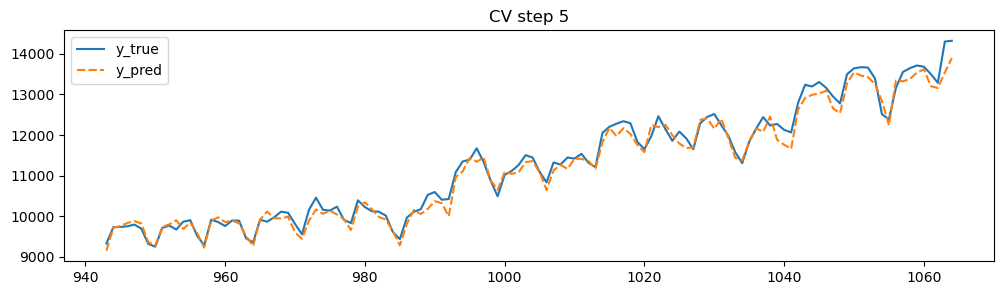

LGBM CV step 5 MAE: 154.59080375465615


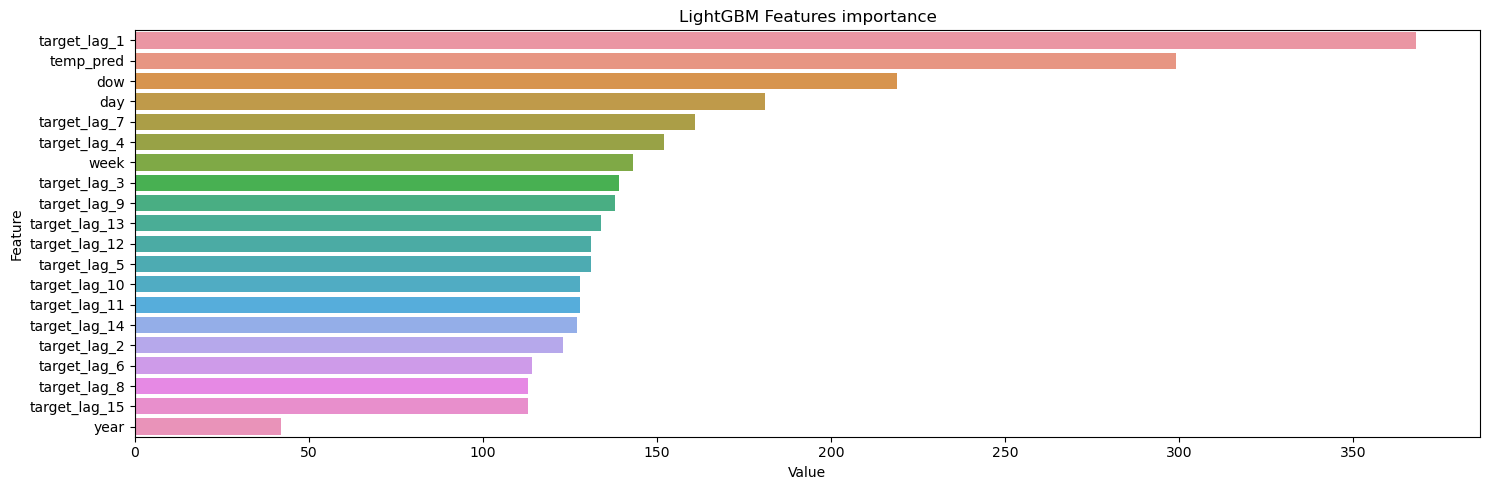

In [12]:
lgbm_maes = lgbm_cross_val(cols_to_drop=['date', 'target'])

In [13]:
print(f'LGBM mean MAE = {np.mean(lgbm_maes)}')

LGBM mean MAE = 186.7281802126258
